<a href="https://colab.research.google.com/github/Shalini-Mirani/ADSLAB/blob/main/ADSEXP7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Libraries

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.linear_model import LinearRegression

#load the data

In [39]:

from statsmodels.tsa.arima_model import ARMA
data=pd.read_csv("/content/stocks.csv")
data.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


#Data Cleaning

In [40]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     248 non-null    object 
 1   Date       248 non-null    object 
 2   Open       248 non-null    float64
 3   High       248 non-null    float64
 4   Low        248 non-null    float64
 5   Close      248 non-null    float64
 6   Adj Close  248 non-null    float64
 7   Volume     248 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 15.6+ KB


In [41]:
data.isnull().sum()

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [42]:
data.columns

Index(['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume'],
      dtype='object')

#EDA

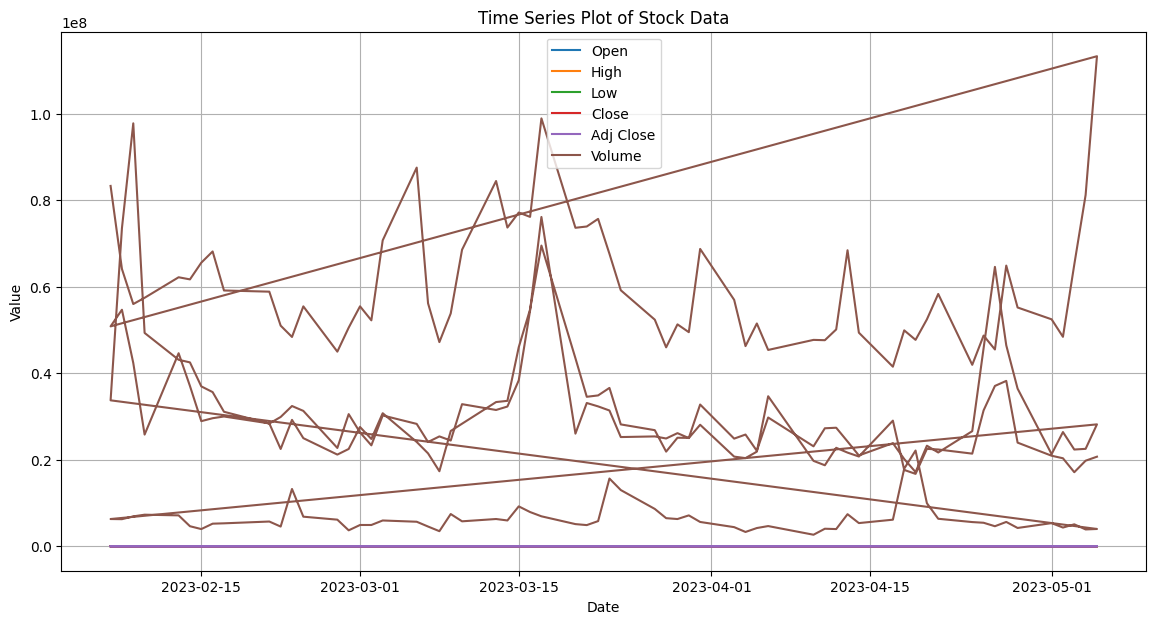

In [43]:
# Convert 'Date' column to datetime if it's not already in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Plotting time series for each column
plt.figure(figsize=(14, 7))

# Plot 'Open'
plt.plot(data['Date'], data['Open'], label='Open')

# Plot 'High'
plt.plot(data['Date'], data['High'], label='High')

# Plot 'Low'
plt.plot(data['Date'], data['Low'], label='Low')

# Plot 'Close'
plt.plot(data['Date'], data['Close'], label='Close')

# Plot 'Adj Close'
plt.plot(data['Date'], data['Adj Close'], label='Adj Close')

# Plot 'Volume'
plt.plot(data['Date'], data['Volume'], label='Volume')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot of Stock Data')
plt.legend()
plt.grid(True)
plt.show()

# Plot time series for each ticker

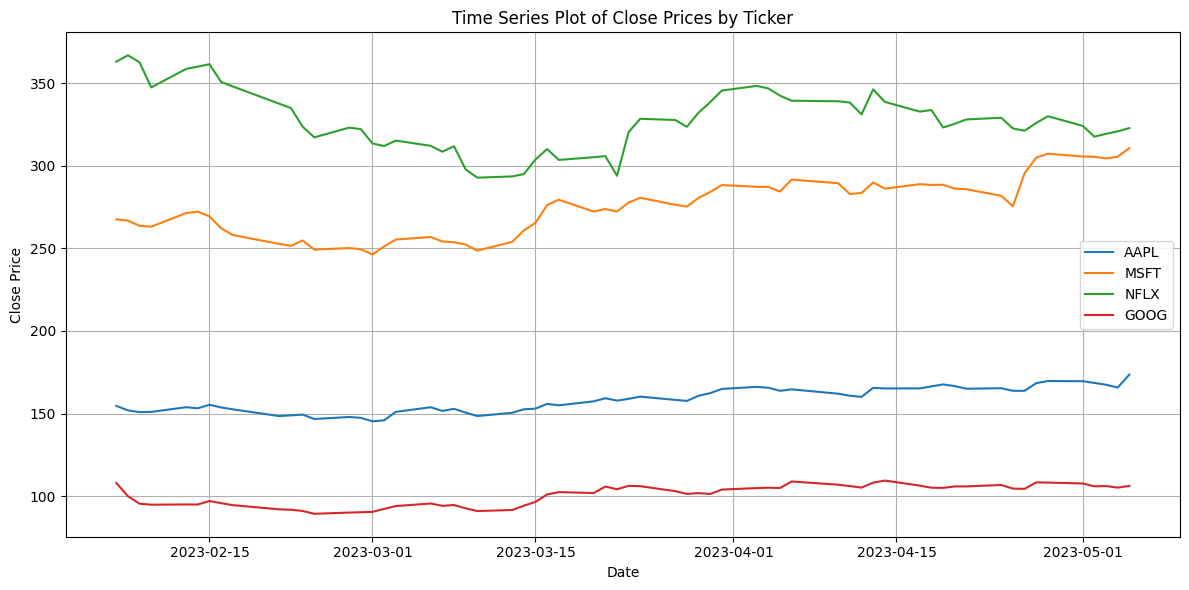

In [44]:
data['Date'] = pd.to_datetime(data['Date'])

# Get unique tickers
unique_tickers = data['Ticker'].unique()

# Plot time series for each ticker
plt.figure(figsize=(12, 6))
for ticker in unique_tickers:
    ticker_data = data[data['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Close'], label=ticker)

plt.title('Time Series Plot of Close Prices by Ticker')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

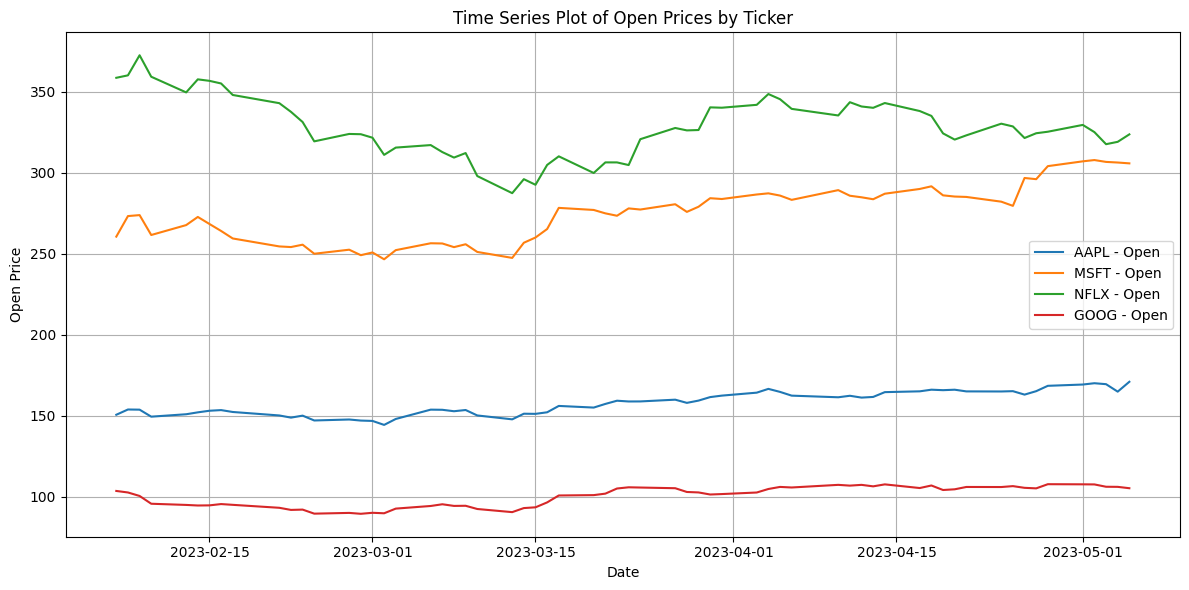

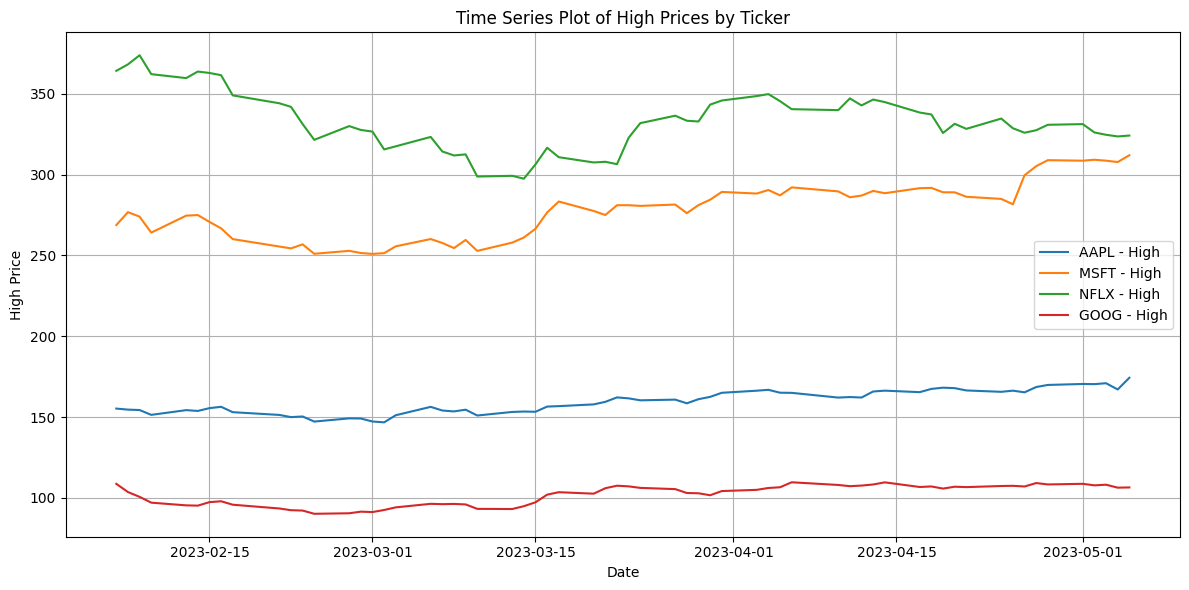

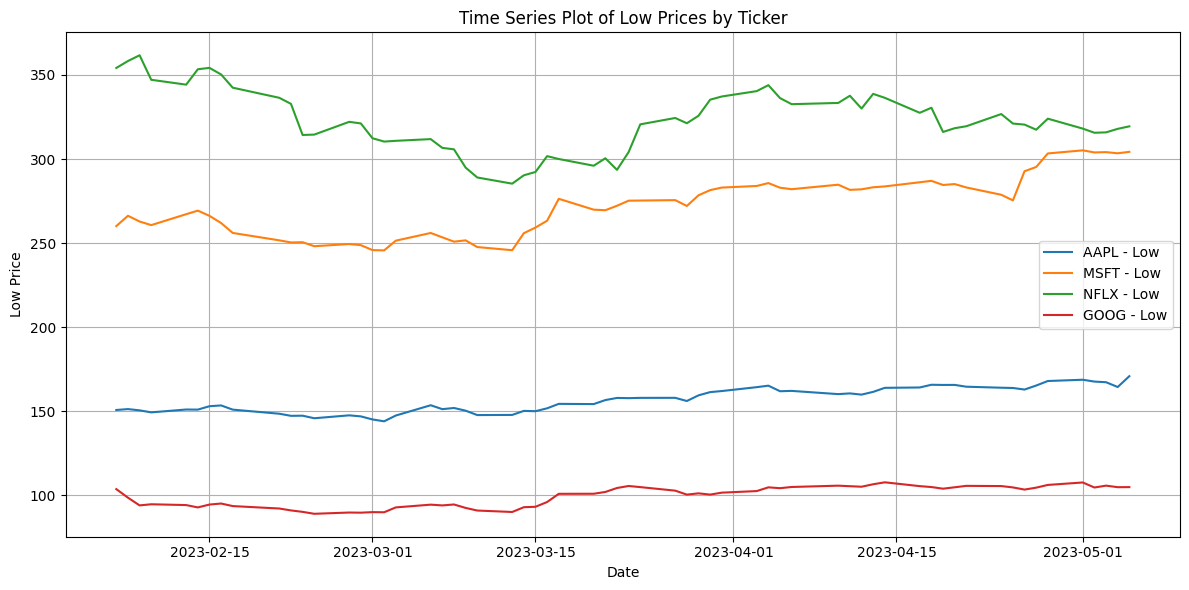

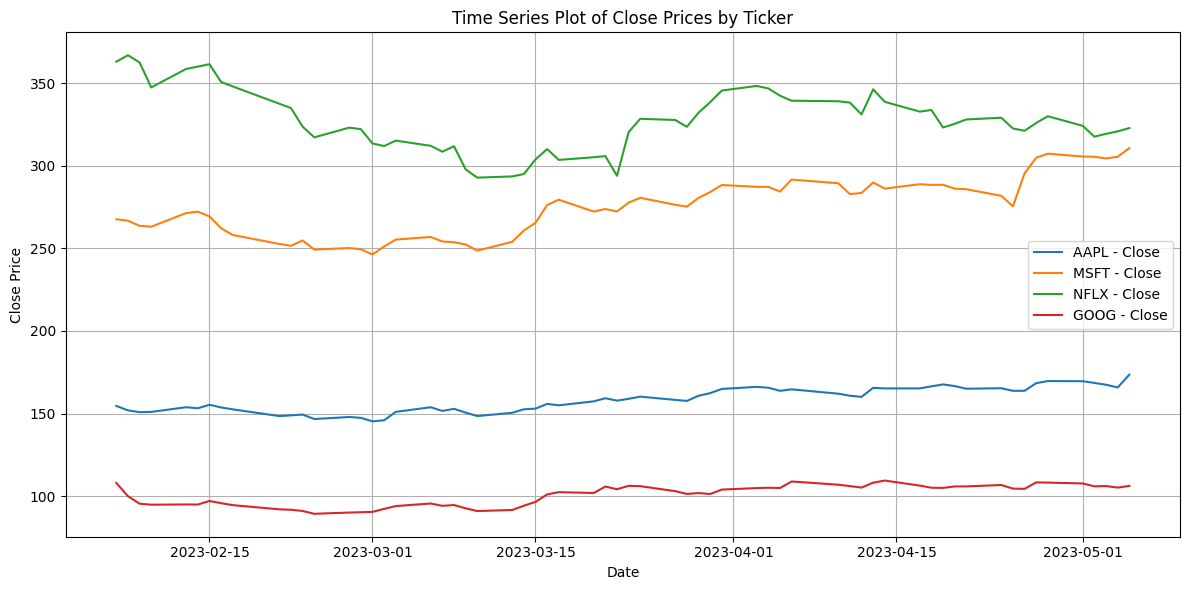

In [45]:
# Plot time series for each ticker and each relevant column
columns_to_plot = ['Open', 'High', 'Low', 'Close']  # Add more columns if needed
plt.figure(figsize=(12, 8))

for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    for ticker in unique_tickers:
        ticker_data = data[data['Ticker'] == ticker]
        plt.plot(ticker_data['Date'], ticker_data[column], label=f"{ticker} - {column}")

    plt.title(f'Time Series Plot of {column} Prices by Ticker')
    plt.xlabel('Date')
    plt.ylabel(f'{column} Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot histograms for each column

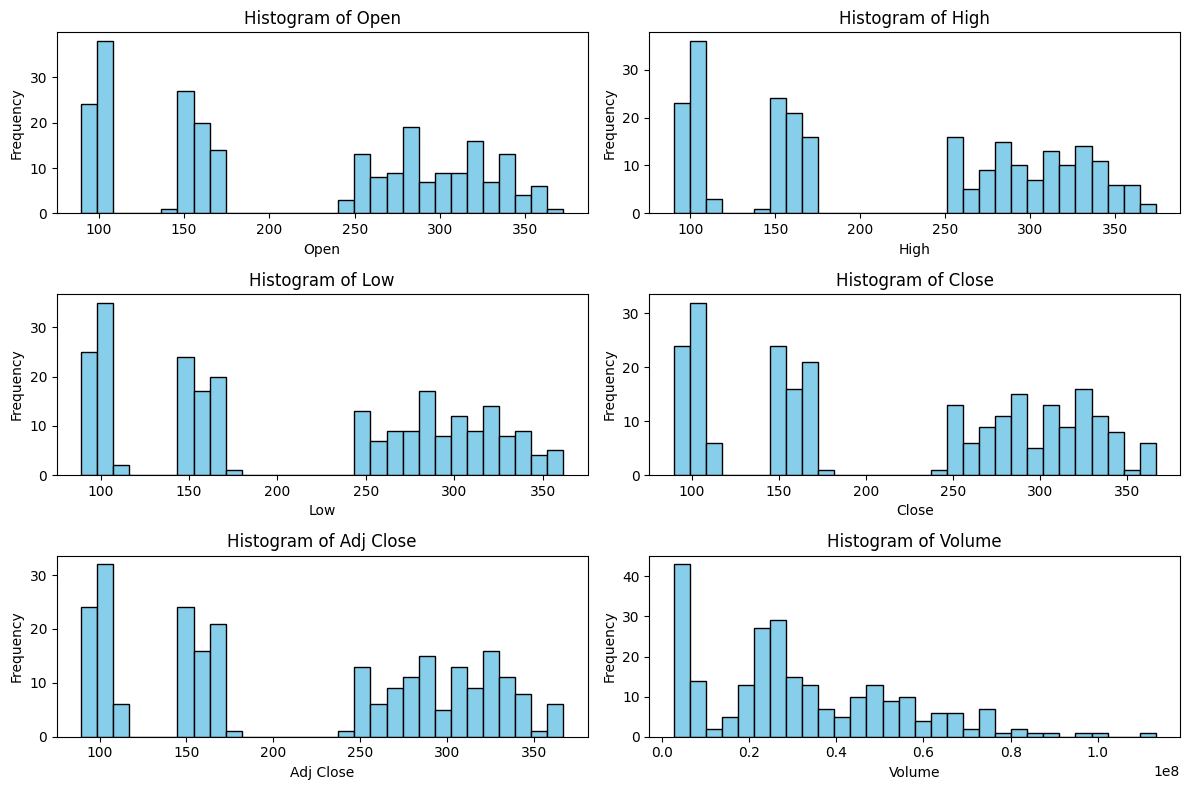

In [46]:
columns_to_plot = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


plt.figure(figsize=(12, 8))

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(3, 2, i)
    plt.hist(data[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Function for evaluating forecast accuracy

In [70]:
date_column = 'Date'
target_column = 'Close'


def evaluate_forecast(actual, forecast, seasonal_period=None):
    mae = np.mean(np.abs(actual - forecast))
    mse = np.mean((actual - forecast)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Root Mean Square Error (RMSE): {rmse:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

    if seasonal_period:
        mase = compute_mase(actual, forecast, seasonal_period)
        print(f'Mean Absolute Scaled Error (MASE): {mase:.2f}')

In [71]:
# Function for computing Mean Absolute Percentage Error (MAPE)
def compute_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# Function for computing Mean Absolute Scaled Error (MASE)
def compute_mase(actual, forecast, seasonal_period):
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    naive_forecast = actual.shift(seasonal_period)
    naive_errors = np.abs(actual - naive_forecast)
    mean_naive_error = np.mean(naive_errors)
    mase = mean_error / mean_naive_error
    return mase

# Average Method
def average_method(data):
    forecast = pd.Series(data[target_column].mean(), index=data.index)
    return forecast

# Moving Average
def moving_average(data, window):
    forecast = data[target_column].rolling(window=window).mean()
    return forecast

# Linear Regression & ARIMA model

In [72]:

def linear_regression(data, n_test):
    train = data[:-n_test]
    test = data[-n_test:]

    X_train = np.arange(len(train)).reshape(-1, 1)
    y_train = train[target_column]

    X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
    y_test = test[target_column]

    model = LinearRegression()
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    return forecast

#
def arima_model(data, order):
    model = ARIMA(data[target_column], order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(data))
    return forecast

# Exponential Smoothing
def exponential_smoothing(data):
    model = SimpleExpSmoothing(data[target_column])
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(data))
    return forecast

# Split data into train and test sets & Apply different methods

In [63]:

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

#
forecast_average = average_method(train_data)
forecast_moving_avg = moving_average(train_data, window=10)
forecast_linear_regression = linear_regression(train_data, len(test_data))
forecast_arima = arima_model(train_data, order=(5,1,0))
forecast_exponential_smoothing = exponential_smoothing(train_data)

# Plot actual vs forecasted data

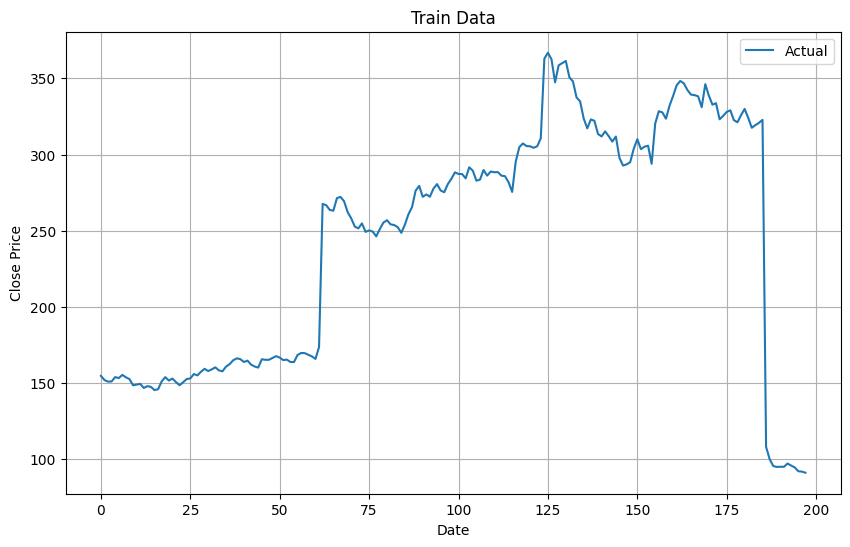

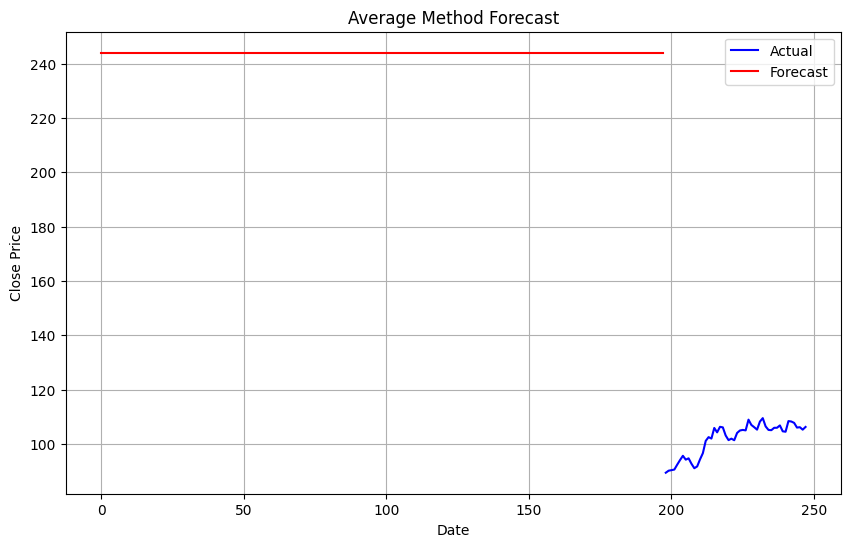

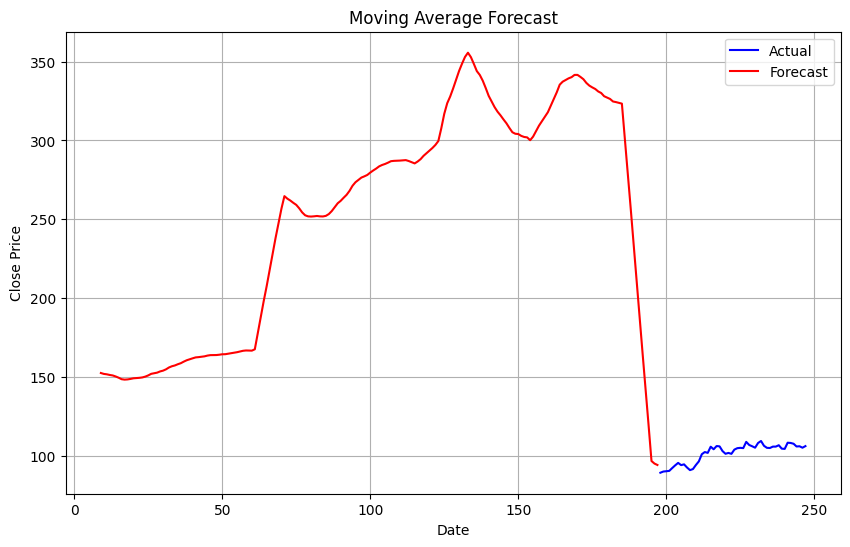

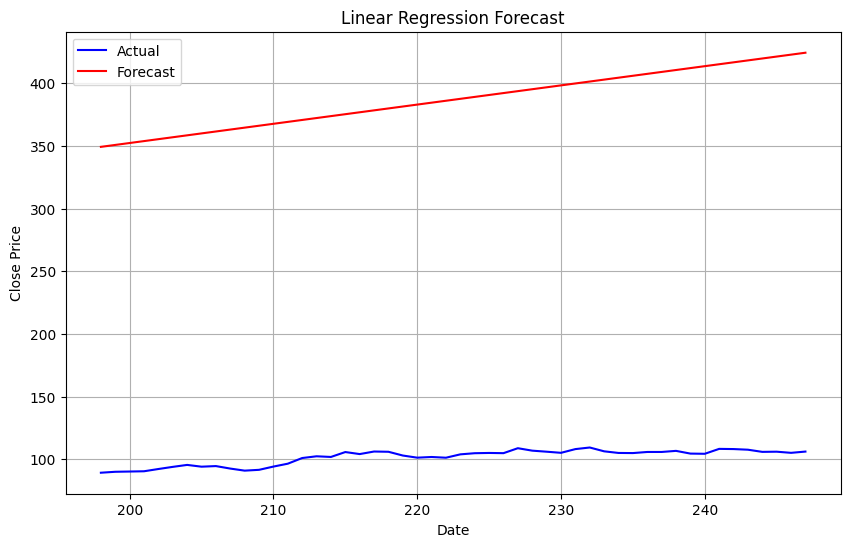

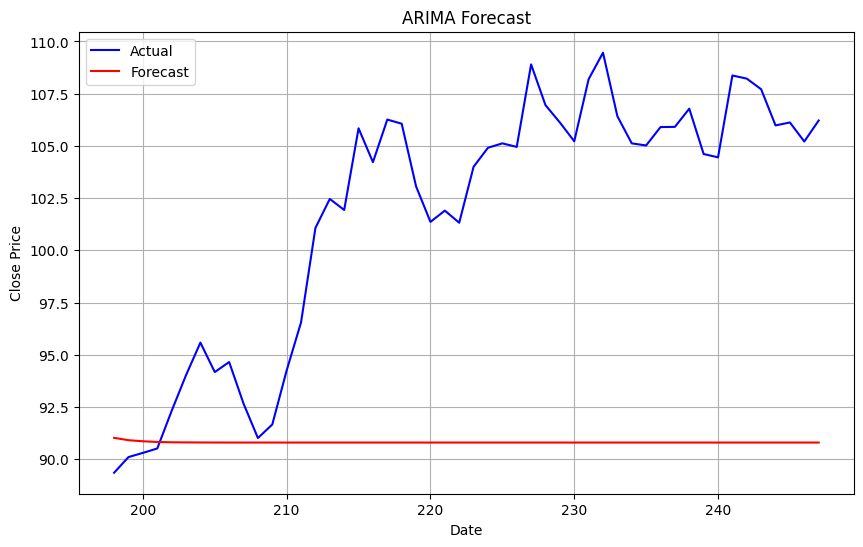

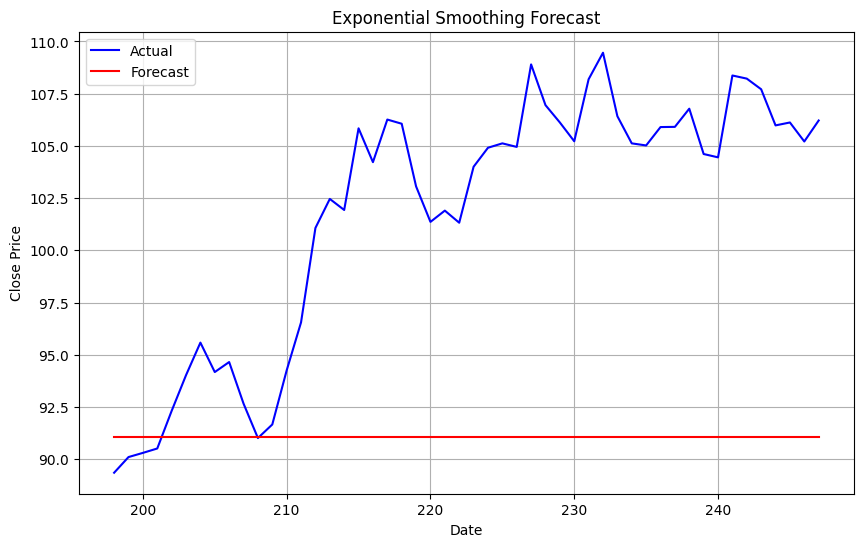

In [66]:

def plot_forecast(actual, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual[target_column], label='Actual', color='blue')
    plt.plot(forecast.index, forecast, label='Forecast', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot results
plot_time_series(train_data, title='Train Data')

plot_forecast(test_data, forecast_average, title='Average Method Forecast')
plot_forecast(test_data, forecast_moving_avg, title='Moving Average Forecast')
plot_forecast(test_data, pd.Series(forecast_linear_regression, index=test_data.index), title='Linear Regression Forecast')
plot_forecast(test_data, pd.Series(forecast_arima, index=test_data.index), title='ARIMA Forecast')
plot_forecast(test_data, pd.Series(forecast_exponential_smoothing, index=test_data.index), title='Exponential Smoothing Forecast')

# Evaluate forecast accuracy

In [68]:

actual_values = test_data[target_column]

print("\nLinear Regression:")
evaluate_forecast(actual_values, forecast_linear_regression)

print("\nARIMA:")
evaluate_forecast(actual_values, forecast_arima)

print("\nExponential Smoothing:")
evaluate_forecast(actual_values, forecast_exponential_smoothing)



Linear Regression:
Mean Absolute Error (MAE): 285.04
Root Mean Square Error (RMSE): 285.56
Mean Absolute Percentage Error (MAPE): 280.36%

ARIMA:
Mean Absolute Error (MAE): 11.10
Root Mean Square Error (RMSE): 12.55
Mean Absolute Percentage Error (MAPE): 10.59%

Exponential Smoothing:
Mean Absolute Error (MAE): 10.86
Root Mean Square Error (RMSE): 12.30
Mean Absolute Percentage Error (MAPE): 10.36%
